# RU-WRF 4.1: Create map of Air Temperature at 2m

_Written by Lori Garzio, June 9, 2020_

[Rutgers Center for Ocean Observing Leadership](https://rucool.marine.rutgers.edu/) (RUCOOL)

This notebook demonstrates how to access data from the Rutgers University Weather Research and Forecasting Model (RU-WRF 4.1) from the [RUWRF THREDDs server](http://tds.marine.rutgers.edu/thredds/cool/ruwrf/catalog.html), subset the data for a specific time range and defined latitude/longitude grid, grab Air Temperature at 2m from the file, plot a pseudocolor map for each hour output of the model, add contours and map feature layers, and save the plots to your local machine.

_**WARNING**: the model output is very large and these plots take several minutes to generate. Please restrict your time range to <24 hours to avoid crashing the THREDDs server._

In [1]:
# import the required packages for data access and plotting
import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Data Access

The RU-WRF 4.1 THREDDs server can be accessed [here](http://tds.marine.rutgers.edu/thredds/cool/ruwrf/catalog.html). For this example, we will be using the [Best](http://tds.marine.rutgers.edu/thredds/catalog/cool/ruwrf/wrf_4_1_3km_processed/catalog.html?dataset=cool/ruwrf/wrf_4_1_3km_processed/WRF_4.1_3km_Processed_Dataset_Best) dataset from the WRF 4.1 3km Processed Dataset, however the 9km Processed Dataset can be accessed in the same way, has the same file format and contains the same variables.

Once you've located the Best dataset and reviewed the documentation, you can access the data using Python via the Data URL found in the OPENDAP link. You will also need to specify: 

* the path to the local directory to which you want to save the plots
* the minimum and maximum latitude and longitudes you want to plot
* start and end times you want to subset to plot (**reminder**: keep to <24 hours)

_Some important information from the metadata page in the THREDDs server about time and geospatial coverage for this dataset:_

**Geospatial Coverage:**
* Longitude: -80.45 to -68.55 degrees_east
* Latitude: 34.32 to 43.15 degrees_north
* Altitude: 30.0 to 250.0 Resolution=10.0 m (positive is up)

**Start Time:** 2019-01-01T00:00:00Z

In [2]:
# data url
wrf_file = 'http://tds.marine.rutgers.edu/thredds/dodsC/cool/ruwrf/wrf_4_1_3km_processed/WRF_4.1_3km_Processed_Dataset_Best'

# save file directory - change this to a local directory
save_dir = '/Users/lgarzio/Documents/rucool/tutorials'

# define the limits for the 3km model to subset and plot
model_lims = dict(minlon=-80, maxlon=-69, minlat=35, maxlat=43)

# start and end times for plotting
start_time = dt.datetime(2020, 6, 9, 0, 0, 0)
end_time = dt.datetime(2020, 6, 9, 4, 0, 0)

Next, we'll use [xarray](https://pypi.org/project/xarray/) to open and subset the RU-WRF data file based on the start and end times you entered above.

In [3]:
# open the dataset
ds = xr.open_dataset(wrf_file, mask_and_scale=False)

# subset based on time
ds = ds.sel(time=slice(start_time, end_time))

# print the dataset to see the dimensions, coordinates, variables, etc
ds

<xarray.Dataset>
Dimensions:      (height: 23, south_north: 324, time: 5, west_east: 324)
Coordinates:
    XLONG        (south_north, west_east) float32 ...
    XLAT         (south_north, west_east) float32 ...
  * height       (height) int32 30 40 50 60 70 80 90 ... 200 210 220 230 240 250
  * time         (time) datetime64[ns] 2020-06-09 ... 2020-06-09T04:00:00
    time_run     (time) datetime64[ns] ...
Dimensions without coordinates: south_north, west_east
Data variables:
    T2           (time, south_north, west_east) float32 ...
    SWDOWN       (time, south_north, west_east) float32 ...
    LWUPB        (time, south_north, west_east) float32 ...
    GLW          (time, south_north, west_east) float32 ...
    PSFC         (time, south_north, west_east) float32 ...
    RAINC        (time, south_north, west_east) float32 ...
    RAINNC       (time, south_north, west_east) float32 ...
    RAINSH       (time, south_north, west_east) float32 ...
    U10          (time, south_north, wes

In [4]:
# grab the time, latitude, and longitude variables
time = ds['time']
lon = ds['XLONG']
lat = ds['XLAT']

# print the time variable - this subset contains data from within the requested timeframe
time

<xarray.DataArray 'time' (time: 5)>
array(['2020-06-09T00:00:00.000000000', '2020-06-09T01:00:00.000000000',
       '2020-06-09T02:00:00.000000000', '2020-06-09T03:00:00.000000000',
       '2020-06-09T04:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 2020-06-09 ... 2020-06-09T04:00:00
    time_run  (time) datetime64[ns] ...
Attributes:
    long_name:            Forecast time for ForecastModelRunCollection
    standard_name:        time
    missing_value:        nan
    _CoordinateAxisType:  Time

Next, we'll look at the latitude variable. Since latitude and longitude are 2D arrays we will need to geospatially subset the data by creating indices to use in the subsetting. We'll create those indices by finding where the latitude and longitude values are within the limits we defined above.

In [5]:
# 2D array
print('Latitude shape: {}'.format(np.shape(lat)))
lat.values

Latitude shape: (324, 324)


array([[34.321144, 34.32268 , 34.324215, ..., 34.324215, 34.32268 ,
        34.321144],
       [34.348   , 34.349537, 34.35108 , ..., 34.35108 , 34.349537,
        34.348   ],
       [34.37486 , 34.376396, 34.37794 , ..., 34.37794 , 34.376396,
        34.37486 ],
       ...,
       [42.95856 , 42.960304, 42.962032, ..., 42.962032, 42.960304,
        42.95856 ],
       [42.985413, 42.987152, 42.988888, ..., 42.988888, 42.987152,
        42.985413],
       [43.012268, 43.014008, 43.015747, ..., 43.015747, 43.014008,
        43.012268]], dtype=float32)

In [6]:
# create boolean indices where lat/lon are within defined boundaries
lon_ind = np.logical_and(lon > model_lims['minlon'], lon < model_lims['maxlon'])
lat_ind = np.logical_and(lat > model_lims['minlat'], lat < model_lims['maxlat'])

# print the lon_ind to see what the code above created
lon_ind

<xarray.DataArray 'XLONG' (south_north: 324, west_east: 324)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    XLONG    (south_north, west_east) float32 -79.76373 -79.7312 ... -68.55237
    XLAT     (south_north, west_east) float32 34.321144 34.32268 ... 43.012268
Dimensions without coordinates: south_north, west_east

In [7]:
# find i and j indices of lon/lat in boundaries
ind = np.where(np.logical_and(lon_ind, lat_ind))

We will use this index when we grab the temperature data to plot at every time step.

## Set up plot for one timestamp

Here is a function to plot the Air Temperature data, add contours at defined temperature levels, add map features to the plot, and save the plot to a directory on your local machine (if the file path is provided).

In [8]:
def plot_2m_airtemp(plt_ttl, clabel, lon_data, lat_data, data, save_figname=None):
    """
    Create a pcolormesh surface map of air temperature at 2m with contours
    plt_ttl: title for the plot
    clabel: label for the color bar
    lon_data: longitude data
    lat_data: latitude data
    data: variable data
    save_figname: optional, full file path to save directory and save filename
    """
    # set up the map
    lccproj = ccrs.LambertConformal(central_longitude=-74.5, central_latitude=38.8)
    fig, ax = plt.subplots(figsize=(8, 9), subplot_kw=dict(projection=lccproj))

    plt.subplots_adjust(right=0.88)  # adjust the right margin of the plot
    plt.title(plt_ttl, fontsize=17)  # add the title

    # format the spacing of the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)
    fig.add_axes(cax)

    # plot the data
    h = ax.pcolormesh(lon_data, lat_data, data, vmin=-20, vmax=110, 
                      cmap='jet', transform=ccrs.PlateCarree())

    # add the color bar
    cb = plt.colorbar(h, cax=cax)
    cb.set_label(label=clabel, fontsize=14)  # add the label on the colorbar
    cb.ax.tick_params(labelsize=12)  # format the size of the tick labels

    # add contours
    contour_list = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # define contour levels
    cs = ax.contour(lon_data, lat_data, data, contour_list, colors='black', 
                    linewidths=.5, transform=ccrs.PlateCarree())
    ax.clabel(cs, inline=True, fontsize=10.5, fmt='%d')

    # add the latitude and longitude gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, 
                      linestyle='dotted', x_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}

    # add map features
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m')
    ax.add_feature(land, zorder=5, edgecolor='black', facecolor='none')

    state_lines = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax.add_feature(cfeature.BORDERS, zorder=6)
    ax.add_feature(state_lines, zorder=7, edgecolor='black')

    # save the figure only if a figure path is provided
    if save_figname is not None:
        plt.savefig(save_figname, dpi=200)
        
    # display the figure then close it
    plt.show()
    plt.close()

Now, we will get the data for Air Temperature at 2m just at the first timestamp in the time array, subset the grid using the latitude/longitude index created earlier, convert the units from K to F, and pass all of the information to the plotting function to create the image.

In [9]:
# get the data for Air Temperature at 2m at the first timestamp in the time array
t = time[0]  # grab the first timestamp
T2 = ds.T2.sel(time=t.values)
varname = T2.long_name
print(T2)

<xarray.DataArray 'T2' (south_north: 324, west_east: 324)>
[104976 values with dtype=float32]
Coordinates:
    XLONG     (south_north, west_east) float32 -79.76373 -79.7312 ... -68.55237
    XLAT      (south_north, west_east) float32 34.321144 34.32268 ... 43.012268
    time      datetime64[ns] 2020-06-09
    time_run  datetime64[ns] ...
Dimensions without coordinates: south_north, west_east
Attributes:
    units:          K
    long_name:      Air Temperature at 2m
    _FillValue:     nan
    description:    TEMP at 2 M
    standard_name:  air_temperature
    _ChunkSizes:    [  1 324 324]


In [10]:
# subset data from min i,j lat/lon corner to max i,j lat/lon corner
# there will be some points outside of defined boundaries because grid is not rectangular
T2 = np.squeeze(T2)[range(np.min(ind[0]), np.max(ind[0]) + 1), 
                    range(np.min(ind[1]), np.max(ind[1]) + 1)]
lons = T2['XLONG']
lats = T2['XLAT']

# convert K to F
T2 = T2.values * 9 / 5 - 459.67
print(T2)
print('Shape: {}'.format(np.shape(T2)))

[[80.360565 80.4263   80.06149  ... 68.35489  68.32895  68.28732 ]
 [80.12845  80.4595   80.07065  ... 68.3168   68.305145 68.2742  ]
 [79.94028  82.06229  81.76114  ... 68.312775 68.27469  68.22012 ]
 ...
 [67.67514  67.31424  67.15677  ... 53.331696 53.12796  53.12741 ]
 [67.86136  67.80881  67.25223  ... 53.257904 53.121185 53.028046]
 [67.97073  67.52261  67.42795  ... 53.291473 53.08719  52.948395]]
Shape: (301, 324)


Define information for the plot, like the label names and save file path.

In [11]:
# define labels for plot
# convert timestamp to string
timestr = dt.datetime.strftime(pd.to_datetime(t.values), '%Y-%m-%d %H:%M')
print('Currently plotting: {}'.format(timestr))

# convert time from GMT to EDT
time_edt = pd.to_datetime(t.values) - dt.timedelta(hours=4)
timestr_edt = dt.datetime.strftime(time_edt, '%Y-%m-%d %H:%M')  # convert timestamp to string

# define plot title and color label title
title = 'WRF 4.1 {}\n{} GMT | {} EDT'.format(varname, timestr, timestr_edt)
color_label = 'Air Temperature ($^\circ$F)'

Currently plotting: 2020-06-09 00:00


## Generate Plots

Finally, let's pass the information to the function to create a plot. This time, we won't pass the save file path (the last argument) to the function,  so the plot will be displayed below but not saved to your local machine. After we confirm the plotting function works, we can write a loop to make more than one plot and save those plots to your local machine.

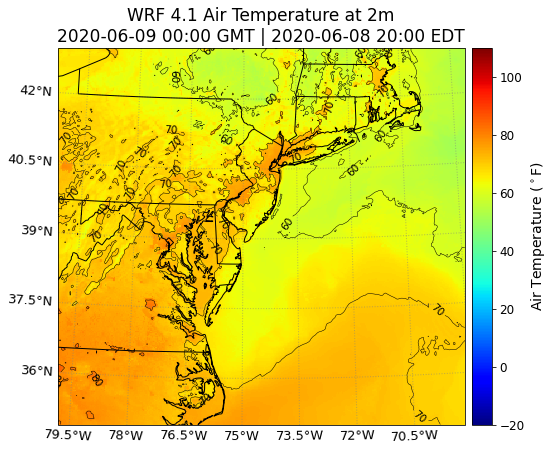

In [12]:
# pass the necessary information to the function to create the plot (without the save file path)
plot_2m_airtemp(title, color_label, lons, lats, T2)

Here is a surface image of air temperature from the model. The data min and max for plotting are set at -20 to 110 degrees F so that multiple plots have the same color range. Those limits can be removed so the colors will dynamically change based on the data range. We're using the 'jet' colormap for this plot - you can start [here](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) for a matplotlib colormap tutorial, and there are many other resources for additional colormaps. The other components of this map can also be customized, such as the contours, gridlines, label sizes, etc.

Now, let's generate plots for the entire subset time range and save those images. This will take several minutes.

Currently plotting: 2020-06-09 00:00
save filepath: /Users/lgarzio/Documents/rucool/tutorials/T2_WRF_3km_20200609_H00.png


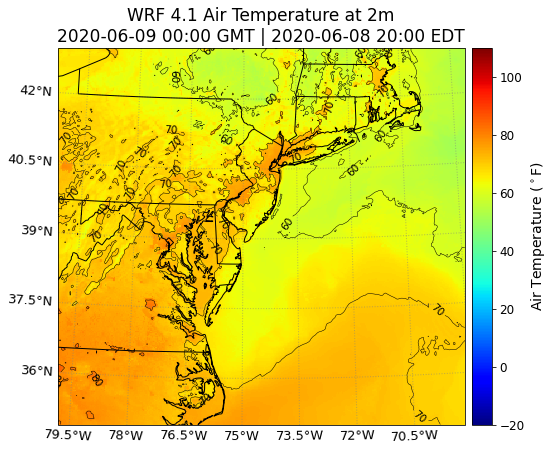

Currently plotting: 2020-06-09 01:00
save filepath: /Users/lgarzio/Documents/rucool/tutorials/T2_WRF_3km_20200609_H01.png


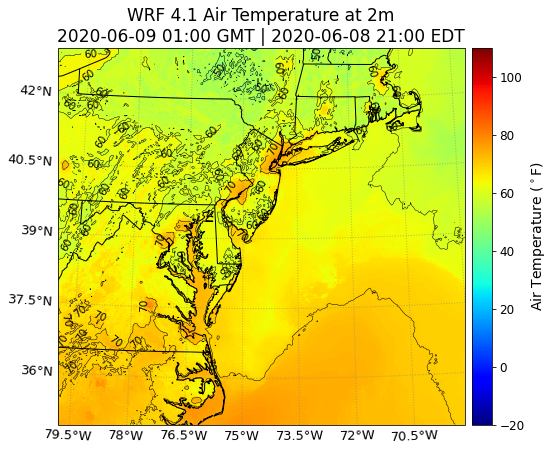

Currently plotting: 2020-06-09 02:00
save filepath: /Users/lgarzio/Documents/rucool/tutorials/T2_WRF_3km_20200609_H02.png


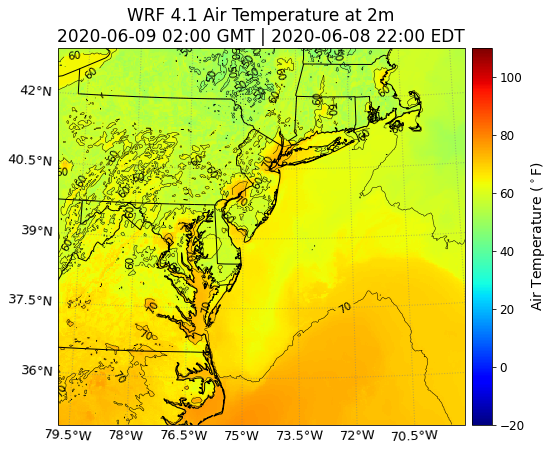

Currently plotting: 2020-06-09 03:00
save filepath: /Users/lgarzio/Documents/rucool/tutorials/T2_WRF_3km_20200609_H03.png


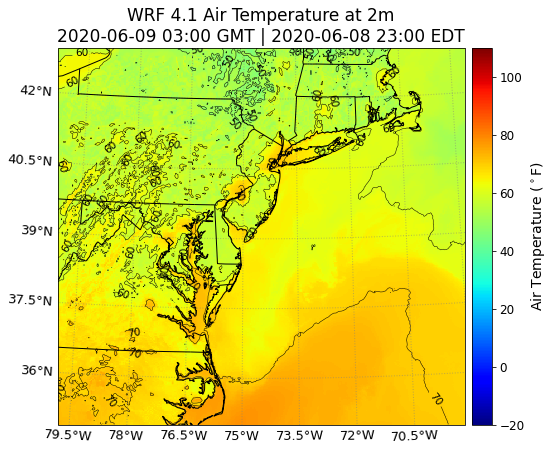

Currently plotting: 2020-06-09 04:00
save filepath: /Users/lgarzio/Documents/rucool/tutorials/T2_WRF_3km_20200609_H04.png


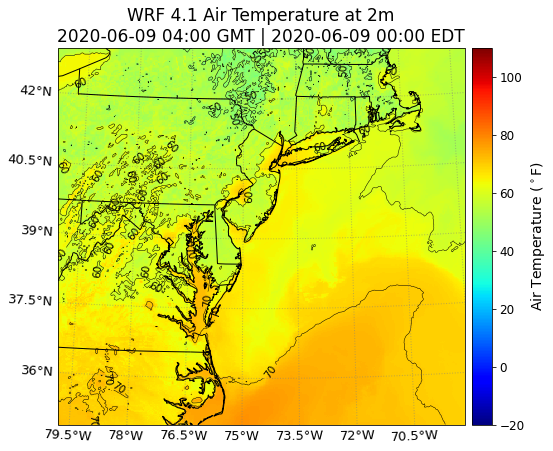

In [13]:
for t in time:
    # get the data for Air Temperature at 2m at the defined timestamp
    T2 = ds.T2.sel(time=t.values)  
    varname = T2.long_name
    
    # subset data from min i,j lat/lon corner to max i,j lat/lon corner
    # there will be some points outside of defined boundaries because grid is not rectangular
    T2 = np.squeeze(T2)[range(np.min(ind[0]), np.max(ind[0]) + 1), 
                        range(np.min(ind[1]), np.max(ind[1]) + 1)]
    lons = T2['XLONG']
    lats = T2['XLAT']

    # convert K to F
    T2 = T2.values * 9 / 5 - 459.67
    
    # define labels for plot
    # convert timestamp to string
    timestr = dt.datetime.strftime(pd.to_datetime(t.values), '%Y-%m-%d %H:%M')
    print('Currently plotting: {}'.format(timestr))

    # convert time from GMT to EDT
    time_edt = pd.to_datetime(t.values) - dt.timedelta(hours=4)
    timestr_edt = dt.datetime.strftime(time_edt, '%Y-%m-%d %H:%M')  # convert timestamp to string

    # define plot title and color label title
    title = 'WRF 4.1 {}\n{} GMT | {} EDT'.format(varname, timestr, timestr_edt)
    color_label = 'Air Temperature ($^\circ$F)'
    
    # create a full save file path for the image
    model = wrf_file.split('/')[-1].split('_')[2]  # get the model version from the filename
    day = dt.datetime.strftime(pd.to_datetime(t.values), '%Y%m%d')
    hr = dt.datetime.strftime(pd.to_datetime(t.values), '%H')
    figname = 'T2_WRF_{}_{}_H{}.png'.format(model, day, hr)
    sfig = os.path.join(save_dir, figname)
    print('save filepath: {}'.format(sfig))
    
    # pass the necessary information to the function to create the plot, 
    # including the save file path to save plots to local machine
    plot_2m_airtemp(title, color_label, lons, lats, T2, sfig)